In [1]:
# ===== IMPORTS Y CONFIGURACIÓN =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Imports específicos para clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Configuración de visualización
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)
pd.set_option('display.max_columns', None)

In [8]:
# ===== Cargar datos del notebook anterior =====
# Cargar objetos guardados
try:
    with open('../data/processed/analysis_objects.pkl', 'rb') as f:
        data = pickle.load(f)
    
    features_scaled = data['features_scaled']
    target = data['target']
    scaler = data['scaler']
    symptom_cols = data['symptom_cols']
    
    print("Datos cargados exitosamente")
    print(f"Features shape: {features_scaled.shape}")
    print(f"Target shape: {target.shape}")
    print(f"Número de síntomas: {len(symptom_cols)}")
    
except FileNotFoundError:
    print("Error: No se encontró el archivo de datos procesados.")
    print("Ejecutar primero: 01_diabetes_eda_preprocessing.ipynb")
except Exception as e:
    print(f"Error al cargar datos: {e}")

features_scaled.head(10)

Datos cargados exitosamente
Features shape: (520, 16)
Target shape: (520,)
Número de síntomas: 14


,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
0,-0.661367,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1
1,0.821362,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0
2,-0.578993,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0
3,-0.249498,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0
4,0.986110,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1
5,0.574241,1,1,1,0,1,1,0,1,1,0,1,0,1,1,1
6,0.738988,1,1,1,0,1,1,1,0,0,0,1,1,0,0,0
7,1.480353,1,1,1,1,1,0,0,1,1,1,0,1,1,0,0
8,1.562727,1,1,1,0,1,1,1,0,1,1,0,1,1,0,1
9,1.809848,1,0,1,1,1,1,0,1,1,1,0,0,0,1,0


## Clustering General - Determinación del Número Óptimo de Clusters

En esta sección se evalún diferentes números de clusters (k=2 a k=10) para identificar la configuración óptima mediante múltiples métricas:

- **Inertia (Elbow Method)**: Suma de distancias cuadradas intra-cluster. Buscamos el "codo" donde la mejora marginal decrece significativamente.
- **Silhouette Score**: Mide cohesión intra-cluster vs separación inter-cluster. Rango [-1,1], valores cercanos a 1 indican clusters bien definidos.
- **Calinski-Harabasz Index**: Ratio de dispersión entre clusters vs dentro de clusters. Valores altos indican clusters compactos y separados.
- **Davies-Bouldin Index**: Promedio de similitud cluster-to-cluster. Valores bajos indican clusters más distintos.

Evaluando número óptimo de clusters...
    k      inertia  silhouette  calinski_harabasz  davies_bouldin
0   2  1807.199768    0.195075         139.633050        1.793462
1   3  1568.545859    0.193070         119.614525        1.949128
2   4  1444.299789    0.178689         101.231731        1.846948
3   5  1364.397328    0.176464          87.754243        1.993499
4   6  1303.272282    0.192833          78.174752        1.979813
5   7  1248.827878    0.183878          71.580966        1.966555
6   8  1214.407537    0.185681          65.044242        2.089580
7   9  1176.023095    0.177420          60.741370        2.124319
8  10  1141.517901    0.180093          57.228416        1.980559


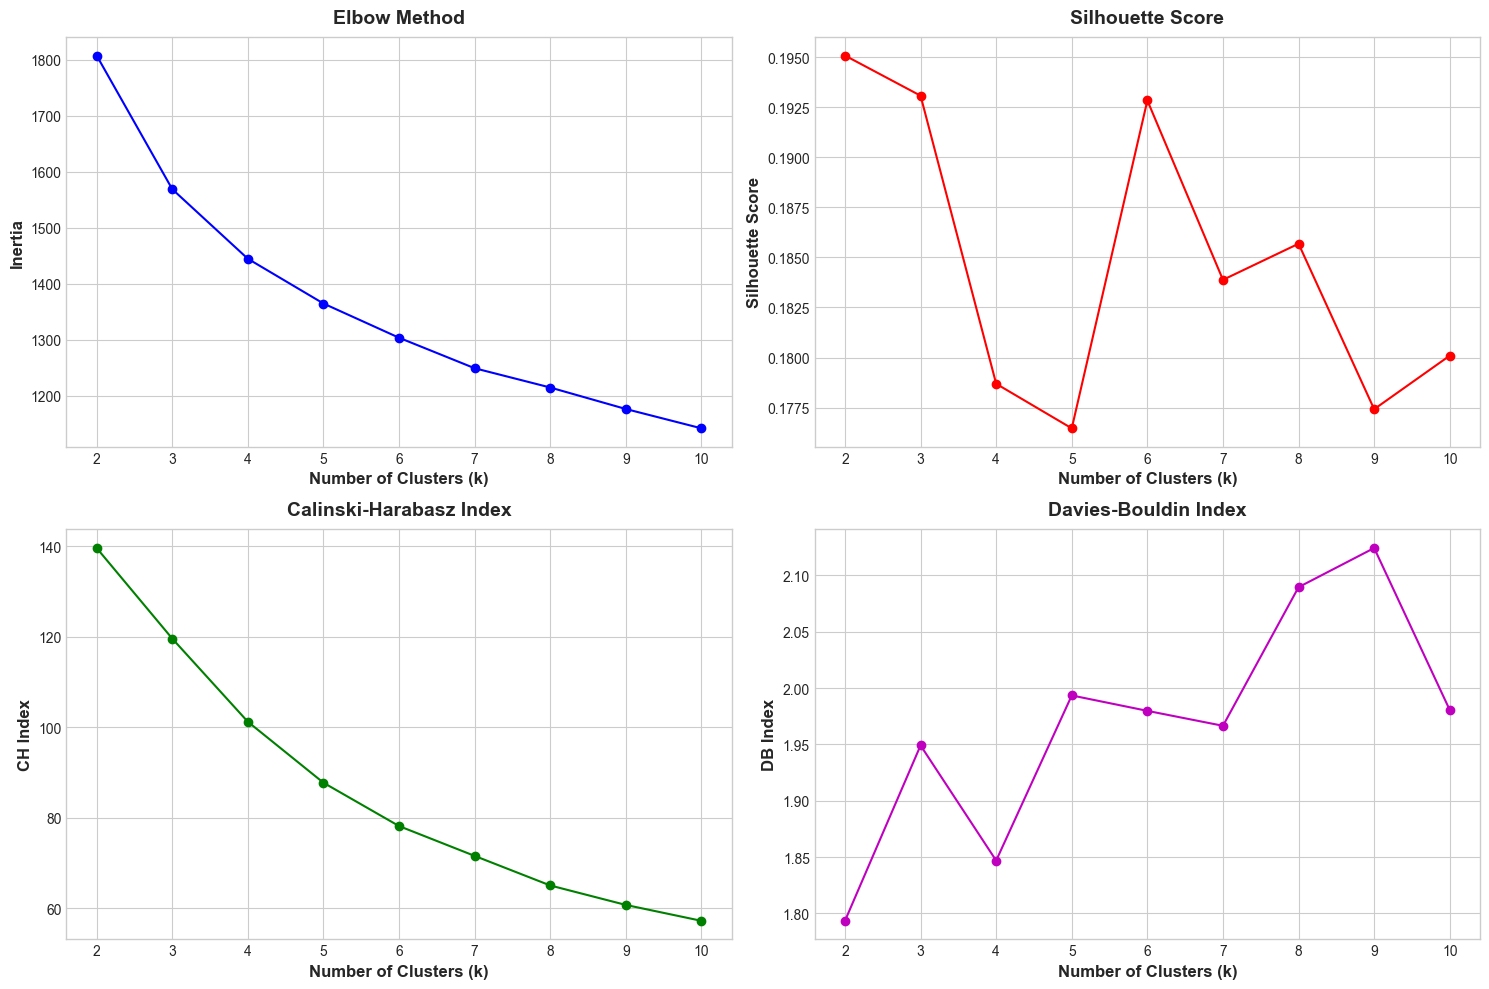

In [9]:
def evaluate_clusters(X, k_range=(2, 11)):
    """Evalúa diferentes números de clusters usando múltiples métricas"""
    
    results = {
        'k': [],
        'inertia': [],
        'silhouette': [],
        'calinski_harabasz': [],
        'davies_bouldin': []
    }
    
    for k in range(k_range[0], k_range[1]):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X)
        
        results['k'].append(k)
        results['inertia'].append(kmeans.inertia_)
        results['silhouette'].append(silhouette_score(X, cluster_labels))
        results['calinski_harabasz'].append(calinski_harabasz_score(X, cluster_labels))
        results['davies_bouldin'].append(davies_bouldin_score(X, cluster_labels))
    
    return pd.DataFrame(results)

def plot_cluster_metrics(metrics_df):
    """Visualiza métricas de evaluación de clusters"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Elbow Method
    axes[0,0].plot(metrics_df['k'], metrics_df['inertia'], 'bo-')
    axes[0,0].set_title('Elbow Method')
    axes[0,0].set_xlabel('Number of Clusters (k)')
    axes[0,0].set_ylabel('Inertia')
    axes[0,0].grid(True)
    
    # Silhouette Score
    axes[0,1].plot(metrics_df['k'], metrics_df['silhouette'], 'ro-')
    axes[0,1].set_title('Silhouette Score')
    axes[0,1].set_xlabel('Number of Clusters (k)')
    axes[0,1].set_ylabel('Silhouette Score')
    axes[0,1].grid(True)
    
    # Calinski-Harabasz Index
    axes[1,0].plot(metrics_df['k'], metrics_df['calinski_harabasz'], 'go-')
    axes[1,0].set_title('Calinski-Harabasz Index')
    axes[1,0].set_xlabel('Number of Clusters (k)')
    axes[1,0].set_ylabel('CH Index')
    axes[1,0].grid(True)
    
    # Davies-Bouldin Index
    axes[1,1].plot(metrics_df['k'], metrics_df['davies_bouldin'], 'mo-')
    axes[1,1].set_title('Davies-Bouldin Index')
    axes[1,1].set_xlabel('Number of Clusters (k)')
    axes[1,1].set_ylabel('DB Index')
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Evaluar clusters para toda la población
print("Evaluando número óptimo de clusters...")
cluster_metrics = evaluate_clusters(features_scaled)
print(cluster_metrics)

# Visualizar métricas
plot_cluster_metrics(cluster_metrics)

## Análisis de Resultados y Selección de K

**Interpretación de las métricas:**

- **Elbow Method**: El codo más pronunciado ocurre entre k=3 y k=4, sugiriendo que k=3 es el punto de inflexión óptimo.
- **Silhouette Score**: k=2 (0.195) y k=6 (0.193) muestran los mejores scores, pero la diferencia es marginal.
- **Calinski-Harabasz**: Confirma k=2 como óptimo, seguido por k=3-4, con decrecimiento consistente posterior.
- **Davies-Bouldin**: k=4 (1.847) muestra el valor más bajo, indicando clusters más distintos.

**Decisión de clustering:**

Seleccionamos **k=3** como configuración principal por:
- Punto de inflexión óptimo en elbow method
- Balance entre simplicidad interpretativa y granularidad clínica
- Silhouette score competitivo (0.193)
- Permite identificar perfiles sintomatológicos diferenciados sin oversegmentación

**k=6** será considerado como alternativa secundaria para análisis comparativo dado su alto silhouette score.

In [10]:
def apply_kmeans_clustering(X, k=3, random_state=42):
    """Aplica K-Means clustering y retorna modelo y labels"""
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    return kmeans, cluster_labels

def calculate_cluster_stats(X, labels, feature_names):
    """Calcula estadísticas descriptivas por cluster"""
    df = pd.DataFrame(X, columns=feature_names)
    df['cluster'] = labels
    
    stats = df.groupby('cluster').agg(['mean', 'std', 'count'])
    return stats

def plot_cluster_visualization(X, labels, title="K-Means Clustering"):
    """Visualiza clusters usando PCA para reducción dimensional"""
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot clusters en espacio PCA
    scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
    ax1.set_title(f'{title} - PCA Visualization')
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.colorbar(scatter, ax=ax1)
    
    # Distribución de clusters
    unique_labels, counts = np.unique(labels, return_counts=True)
    ax2.bar(unique_labels, counts, color=['#440154', '#31688e', '#35b779'])
    ax2.set_title('Cluster Size Distribution')
    ax2.set_xlabel('Cluster')
    ax2.set_ylabel('Number of Patients')
    
    # Añadir porcentajes
    total = len(labels)
    for i, count in enumerate(counts):
        ax2.text(i, count + total*0.01, f'{count}\n({count/total:.1%})', 
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return pca.explained_variance_ratio_

K-Means Clustering Results (k=3)
Silhouette Score: 0.1931
Calinski-Harabasz Score: 119.61
Davies-Bouldin Score: 1.9491
Inertia: 1568.55


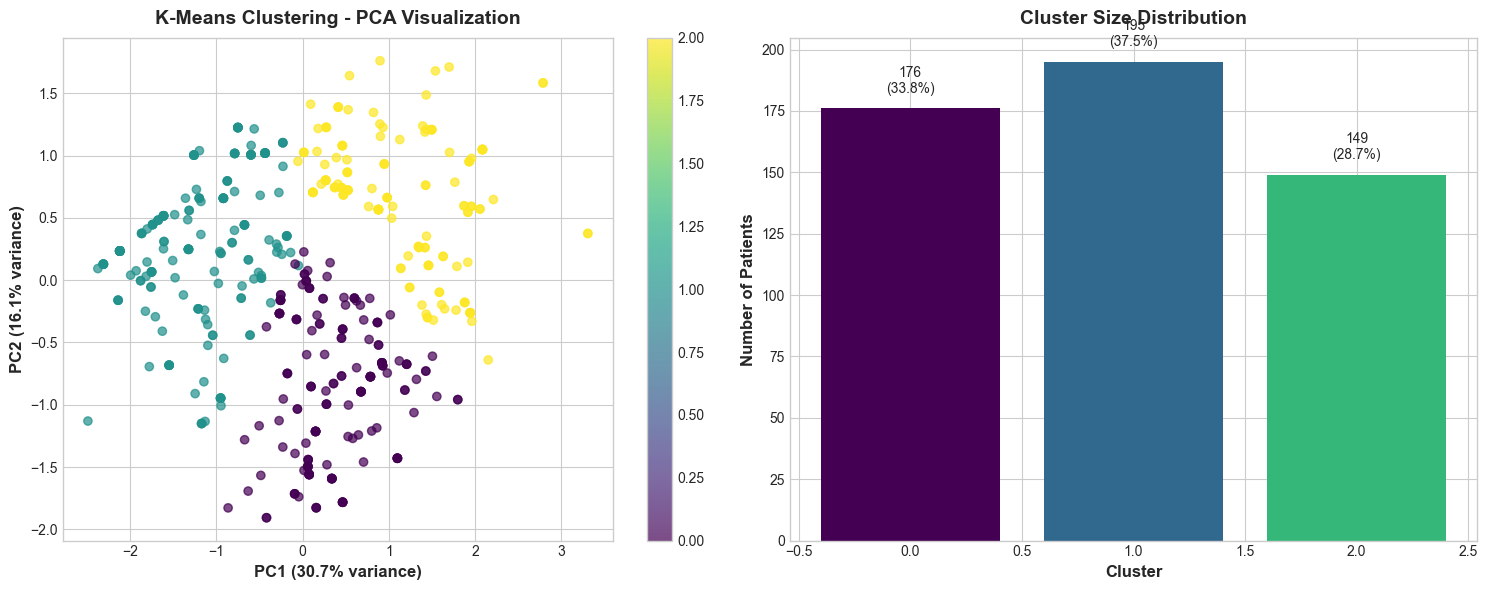


PCA Variance Explained: 30.7% + 16.1% = 46.8%

Cluster Statistics:
         age            Polyuria                 Polydipsia                  \
        mean std count      mean       std count       mean       std count   
cluster                                                                       
0        NaN NaN     0  0.818182  0.386795   176   0.863636  0.344153   176   
1        NaN NaN     0  0.225641  0.419080   195   0.153846  0.361730   195   
2        NaN NaN     0  0.469799  0.500770   149   0.342282  0.476074   149   

        sudden weight loss                  weakness                  \
                      mean       std count      mean       std count   
cluster                                                                
0                 0.795455  0.404520   176  0.767045  0.423920   176   
1                 0.189744  0.393107   195  0.323077  0.468856   195   
2                 0.268456  0.444651   149  0.718121  0.451432   149   

        Polyphagia      

In [11]:
# Aplicar K-Means con k=3
kmeans_model, cluster_labels = apply_kmeans_clustering(features_scaled, k=3)

# Calcular métricas de evaluación
silhouette_avg = silhouette_score(features_scaled, cluster_labels)
calinski_score = calinski_harabasz_score(features_scaled, cluster_labels)
davies_bouldin = davies_bouldin_score(features_scaled, cluster_labels)

print("K-Means Clustering Results (k=3)")
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Calinski-Harabasz Score: {calinski_score:.2f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")
print(f"Inertia: {kmeans_model.inertia_:.2f}")

# Visualizar clustering
variance_explained = plot_cluster_visualization(features_scaled, cluster_labels)
print(f"\nPCA Variance Explained: {variance_explained[0]:.1%} + {variance_explained[1]:.1%} = {sum(variance_explained):.1%}")

# Calcular estadísticas por cluster
feature_names = ['age'] + symptom_cols + ['gender']
cluster_stats = calculate_cluster_stats(features_scaled, cluster_labels, feature_names)
print(f"\nCluster Statistics:")
print(cluster_stats)